In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ElementFraction

In [2]:
df  = pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')
df.head()

,chemicalFormula,licenses,names,preparation,references,Axis Length,Axis Length-conditions,Axis Length-units,Bulk Modulus,Bulk Modulus-conditions,...,Thermal Expansion-conditions,Thermal Expansion-units,Thermal Shock Resistance,Thermal Shock Resistance-conditions,Thermal Shock Resistance-units,Weibull Modulus,Weibull Modulus-conditions,Weibull Strength,Weibull Strength-conditions,Weibull Strength-units
1,SiO2,[{'name': 'NIST_SRD-30'}],[Silica],NaN,"[{'citation': 'Gaseous Corrosion of Ceramics, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3Al2O3.2SiO2.xZrO2.yY2O3,[{'name': 'NIST_SRD-30'}],[Mullite composite],[{'name': 'Hot Pressing'}],[{'citation': 'Thermal Diffusivity/Conductivit...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Al2O3,[{'name': 'NIST_SRD-30'}],[Alumina],[{'name': 'Hot Pressing'}],"[{'citation': 'Mechanical Properties of Pure, ...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Si3N4.xCeO2.ySiC,[{'name': 'NIST_SRD-30'}],[Silicon nitride composite],[{'name': 'Hot Pressing'}],[{'citation': 'Effect of Silicon Carbide Whisk...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Si3N4,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'name': 'Hot Isostatic Pressing'}],[{'citation': 'Corrosion of Silicon Nitride Ce...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare dataset

### Drop non-density materials

In [27]:
# New DataFrame containing only samples with a density value
df = df[df.isnull()['Density'] == False]

In [28]:
df.shape

(398, 161)

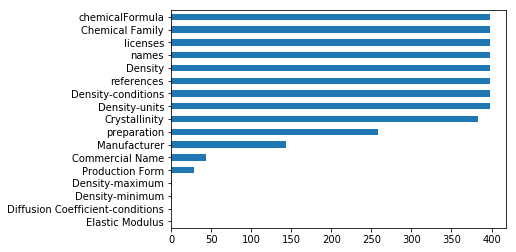

In [29]:
# Plot occurrence of features of the reduced dataset
df.count().sort_values()[-17:].plot.barh()
plt.show()

In [30]:
# Drop all columns that contain less than 300 entries 
# (crystallinity is only features left with NaN)
df = df.dropna(axis=1, thresh=300)

### Clean up columns

#### Check if all density units are the same

In [31]:
# Check if all density units are the same, in which case we don't need the units.
df['Density-units'].unique()

array(['g cm$^{-3}$'], dtype=object)

#### Fill missing crystallinity values

In [33]:
# Determine number of polycrystalline / single crystal samples
N_polyX = df[df['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = df[df['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (354,), Single crystal: (27,)


In [34]:
#Fill NaN values in crystallinity with polycrystalline:
df['Crystallinity'] = df['Crystallinity'].fillna('Polycrystalline')

#### Convert density to float

In [35]:
# Check how density values cannot simply be transformed from string to int

N_errors, N_total = 0, 0
for entry in df['Density']:
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

3.16 (1%)
1 errors in 398 samples


In [36]:
#convert the troublesome density value to a good value
df.set_value(1185, 'Density', '3.16');
df.loc[1185,'Density']

'3.16'

In [37]:
# Convert densities to float
df['Density'] = df['Density'].astype(float)

#### Remove useless columns

In [38]:
#Drop columns that don't contain numerical or categorical data
df = df.drop(['licenses','names','references','Density-units','Density-conditions','Chemical Family'], axis=1)

### Eliminate duplicate materials

In [39]:
N_unique_entries = len(df['chemicalFormula'].unique())
print('There are just {0} unique entries in the {1} materials.'.format(N_unique_entries,df_dens.shape[0]))

There are just 110 unique entries in the 122 materials.


In [40]:
df = df.groupby(['chemicalFormula','Crystallinity'], as_index=False).mean()

### Composition with Chih-Hao's method

In [41]:
df.loc[3892,'chemicalFormula'] = 'BN' #fix 'B-N' to 'BN'

# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

df["flatFormula"] = df["chemicalFormula"].map(formula_parser)
df["composition"] = df["flatFormula"].transform(str_to_composition)

### Composition with Chris' method

In [42]:
# Add second composition column (that doesn't have float stoichiometries; Chris' version)
def make_chem_form_compatible(formula):
    
    for bad_str in ['\.','x', 'y', '\+', '\-', 'z', 'w', '\%', '\^',   # individual characters
                 'Cordierite','hisker','Sialon', # certain words that show up in some formulas
                 '\$(.*?)\$',    # LaTeX expressions
                 '\((.*?)\)',    # bracketed expressions
                 '^\d{1,2}']:    # leading numbers of 1 or 2 digits
        formula = re.sub(bad_str, '', formula)
    
    return formula

# Convert chemical formulas using above function
df["comp_int"] = df["chemicalFormula"].transform(make_chem_form_compatible)

# Converting chemical formula to composition object using
# matminer.utils.conversions.str_to_composition
# which in turn uses pymatgen.core.composition
df["comp_int"] = df["comp_int"].transform(str_to_composition)

In [43]:
df.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,comp_int
0,$\beta$-Si3Al3O3N5,Polycrystalline,3.091000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)","(Si, Al, O, N)"
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,4.380000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)","(Al, O, N, Ti)"
2,0.5SiO2.(0.5-x)Al2O3.xE2O3,Noncrystalline,3.520000,Si5.0O10.0Al2.0O3.0E0.2O0.3,"(Si, O, Al, E0+)","(Si, O, Al, E0+)"
3,3Al2O3.2SiO2,Polycrystalline,3.097167,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)","(Al, O, Si)"
4,3Al2O3.2SiO2.xCordierite,Polycrystalline,2.720000,Al6.0O9.0Si2.0O4.0Co0.1,"(Al, O, Si, Co)","(Al, O, Si)"


In [44]:
sample=5
print('chemical formula: ', df.loc[sample,'chemicalFormula'])
print('composition :', df.loc[sample,'composition'])
print('comp_int :', df.loc[sample,'comp_int'])

chemical formula:  3Al2O3.2SiO2.xSiC
composition : Al6 O13 Si2.1 C0.1
comp_int : Al2 O34 Si2 C1


# Add Additional Features with matminer

In [45]:
df_feat = df.copy() # Create new DataFrame for featurization

### ElementProperty

In [46]:
df_feat.shape

(123, 6)

In [47]:
# Add features with matminer (using the floating point composition by Chih-Hao)
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df_feat = ep_feat.featurize_dataframe(df_feat, col_id="composition", ignore_errors=True)

In [48]:
df_feat.shape

(123, 138)

In [51]:
# List of the new columns
list(set(df_feat.columns) ^ set(df.columns))[:10]

['mean NfUnfilled',
 'maximum MendeleevNumber',
 'mode Column',
 'mean GSmagmom',
 'mean GSbandgap',
 'minimum GSvolume_pa',
 'avg_dev NpUnfilled',
 'mean SpaceGroupNumber',
 'mean Row',
 'mean CovalentRadius']

### ElementFraction

In [55]:
# Adds a column for every element. Values are fraction of atoms that belong to that element.
ep_frac = ElementFraction()
df_feat = ep_frac.featurize_dataframe(df_feat, col_id = "composition", ignore_errors = True)

In [65]:
df_feat.head()

,chemicalFormula,Crystallinity,Density,flatFormula,composition,comp_int,minimum Number,maximum Number,range Number,mean Number,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,$\beta$-Si3Al3O3N5,Polycrystalline,3.091000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)","(Si, Al, O, N)",7.0,14.0,7.0,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,4.380000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)","(Al, O, N, Ti)",7.0,22.0,15.0,10.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5SiO2.(0.5-x)Al2O3.xE2O3,Noncrystalline,3.520000,Si5.0O10.0Al2.0O3.0E0.2O0.3,"(Si, O, Al, E0+)","(Si, O, Al, E0+)",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3Al2O3.2SiO2,Polycrystalline,3.097167,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)","(Al, O, Si)",8.0,14.0,6.0,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3Al2O3.2SiO2.xCordierite,Polycrystalline,2.720000,Al6.0O9.0Si2.0O4.0Co0.1,"(Al, O, Si, Co)","(Al, O, Si)",8.0,27.0,19.0,10.080569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
